In this project, I employ several supervised learning algorithms to model individuals’ income using data collected from the 1994 US Census. The goal of the project is to construct a model that accurately predicts whether an individual makes more than $50,000.

The result of the project is a model that is 87.1% accurate (75.4% F-score) at predicting whether an individual makes more than $50,000 based on 13 datapoints. Training the identical model on the most important 5 datapoints results in a model that is 85.9% accurate (72.8% F-score).

## Explore and Preprocess the Data

The specific tasks break down as follows:

Explore the Data

    a. Plot Histograms for Continuous (Numerical) Feature Distributions
    b. Plot Bar Charts for Discrete (Categories) Feature Distributions
    
Preprocess the Data

    a. Split into Features and Labels
    b. Transform Skewed Continuous Features
    c. Normalize Continuous Features
    d. One-Hot Encode Categorical Features
    e. Suffle and Split the Data
    
Write the Processed Data to File

In [1]:
import numpy as np
import pandas as pd
from time import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

c = pd.read_csv('census.csv')

The outcome (label) is contained in the final column, income.

In [2]:
n_records = c.shape[0]
n_greater_50k = c[c['income']=='>50K'].shape[0]
n_at_most_50k = c[c['income']=='<=50K'].shape[0]
greater_50k_percent = n_greater_50k/n_records

print('                 Total records: {}'.format(n_records))
print(' Individuals with income >$50K: {}'.format(n_greater_50k))
print('Individuals with income <=$50K: {}'.format(n_at_most_50k))
print('        %age with income >$50K: {:.1%}'.format(greater_50k_percent))

                 Total records: 45222
 Individuals with income >$50K: 11208
Individuals with income <=$50K: 34014
        %age with income >$50K: 24.8%


Among the features, there are:

- 5 continuous, numerical features and
- 8 discrete, categorical features

In [3]:
c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  int64  
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
 13  income           45222 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


## Plot Histograms for Continuous Feature Distributions

In [4]:
def plot_continuous_distributions(field, bins=None, xlim_list=None, xtick_list=None):
    fig, (b, h) = plt.subplots(ncols=1, nrows=2, 
                               sharex=True, 
                               gridspec_kw={'height_ratios':[1,3]},
                               figsize=(12,3))
    b.boxplot(c[field],
              widths=0.6,
              vert=False)
    b.set_title(field,
                fontsize=14)
    b.set_yticks([])
    b.set_xticks(xtick_list)
    
    h.hist(c[field],
           bins=bins,
           align='left')
    h.set_xlim(xlim_list)
    h.set_xticks(xtick_list)
    
    for ax in [b, h]:
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.tick_params(
            axis='x',
            bottom=False)
        ax.tick_params(
            axis='y',
            left=False,
            right=False)

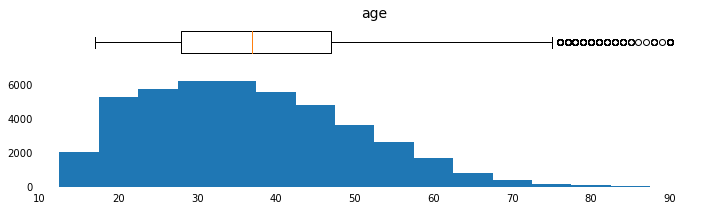

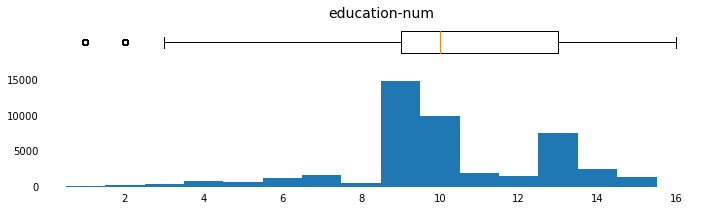

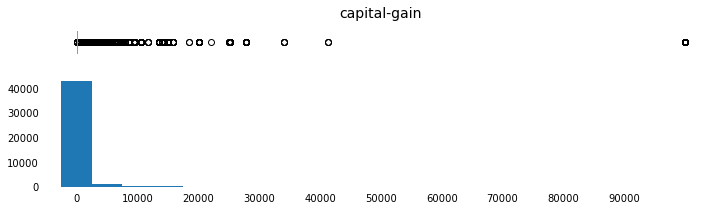

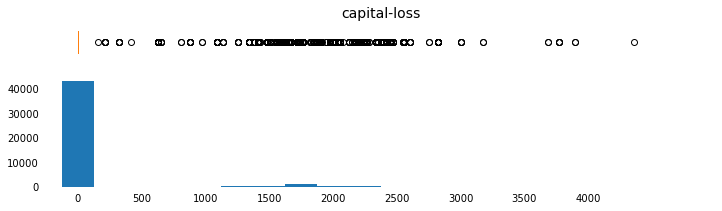

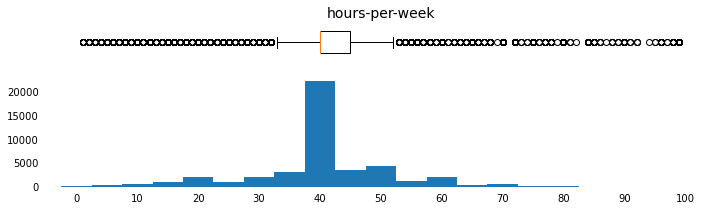

In [5]:
params = [('age',np.arange(15,95,5),[10,95],np.arange(10,100,10)),
          ('education-num',np.arange(0,17,1),[0,17],np.arange(2,18,2)),
          ('capital-gain',np.arange(0,100000,5000),[-5000,105000],
           np.arange(0,100000,10000)),
          ('capital-loss',np.arange(0,4500,250),[-250,5000],np.arange(0,4500,500)),
          ('hours-per-week',np.arange(0,100,5),[-5,105],np.arange(0,110,10))]
for field, bins, xlim_list, x_tick_list in params:
    plot_continuous_distributions(field, bins, xlim_list, x_tick_list)

## Plot Bar Charts for Discrete Feature Distributions

In [6]:
def plot_discrete_distributions(field):
    summary = (pd.DataFrame(c[field].value_counts())
               .reset_index())
    
    if summary.shape[0] > 14:
        other_total = summary[14:][field].sum()
        summary = summary[:14]
        summary = summary.append({'index':'Other',
                                  field:other_total},
                                 ignore_index=True)
    
    summary['percentage'] = round(summary[field]/summary[field].sum()*100.,
                                  0).astype(int)
    labels = summary['index']
    position = summary.index
    counts = summary[field]
    
    plt.figure(figsize=(12,3))

    plt.bar(position, counts, align='center')
    
    if summary.shape[0] > 6:
        rotation = 20
    else:
        rotation = 0
    
    plt.xticks(position, labels, rotation=rotation)

    rects = plt.gca().patches
    for n, r in enumerate(rects):
        height = r.get_height()
        plt.gca().text(r.get_x() + r.get_width() / 2,
                       height + plt.gca().get_ylim()[1]*0.08,
                       str(summary['percentage'][n]) + '%\n' + str(height),
                       ha='center',
                       va='center')

    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.gca().tick_params(
        axis='x',
        bottom=False)
    plt.gca().tick_params(
        axis='y',
        left=False,
        labelleft=False,
        right=False)

    plt.title(field,
              fontsize=14);

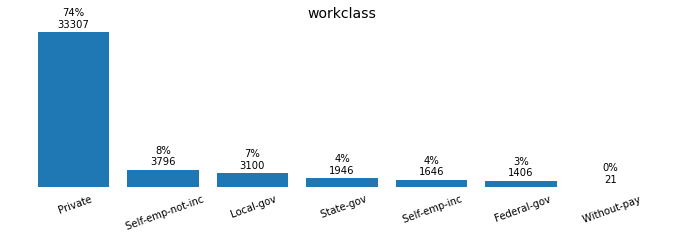

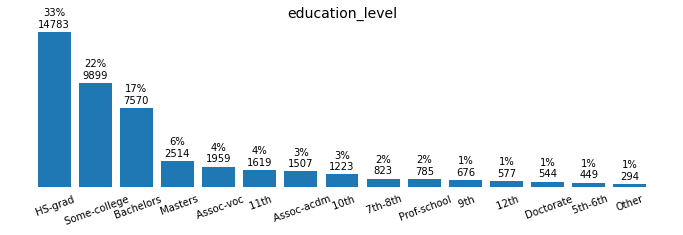

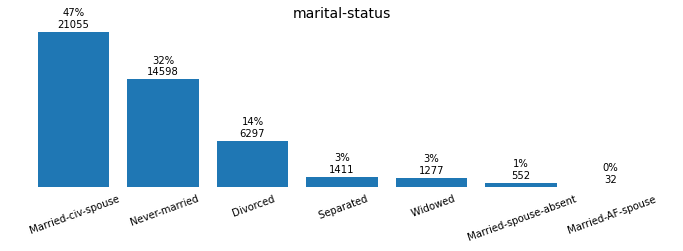

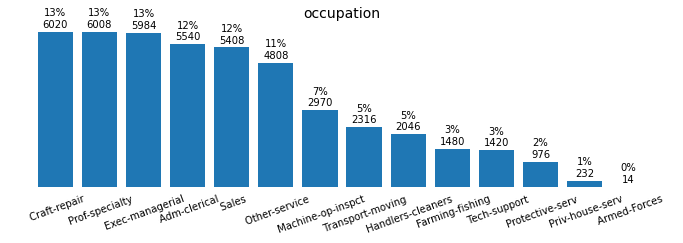

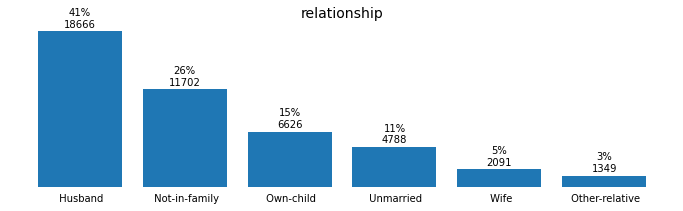

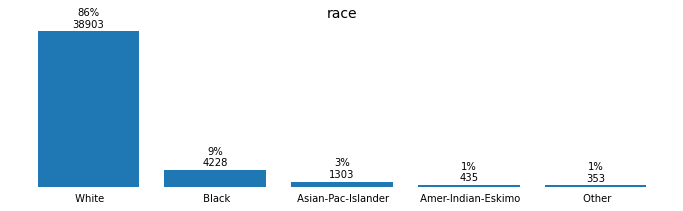

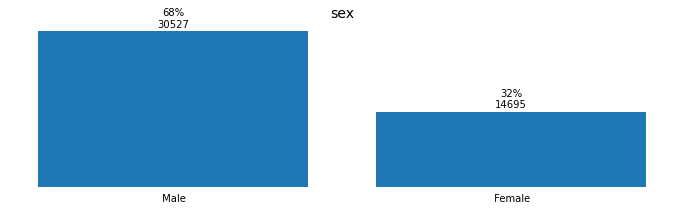

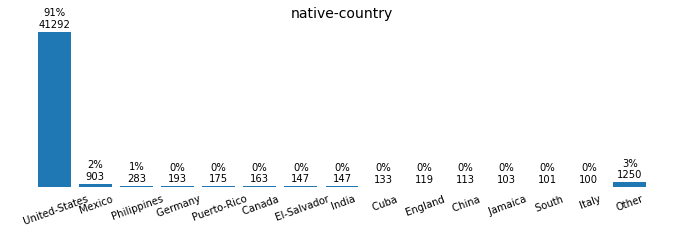

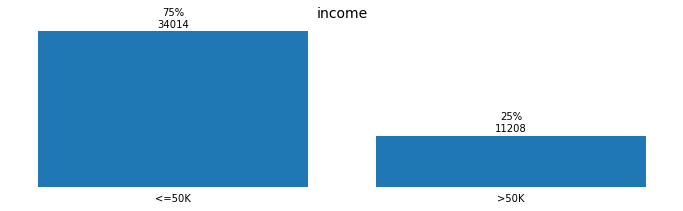

In [7]:
for field in ['workclass', 'education_level', 'marital-status', 'occupation',
              'relationship', 'race', 'sex', 'native-country', 'income']:
    plot_discrete_distributions(field)

# Preprocessing the Data

The data must be preprocessed before it can be used as input for machine learning algorithms. This “preprocessing” consists of handling invalid or missing entries, a broad term for this is cleaning, as well as other formatting and restructuring.

## Split into Features and Labels

In [8]:
labels_raw = c['income']
features_raw = c.drop(columns=['income'])

## Transforming Skewed Continuous Features

capital-gain and capital-loss are both highly-skewed features. The common practice is to apply a logarithmic transformation so that the very large and very small values do not negatively affect the performance of a learning algorithm.

Note that since the logarithm of 0 is undefined, I translate the values by a small amount above 0 in order to apply the logarithm successfully.

Note that the only features that are log transformed, below, are the features in the list of skewed fields.

In [9]:
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

Visualize the change.

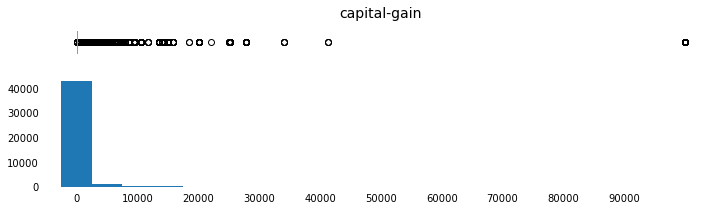

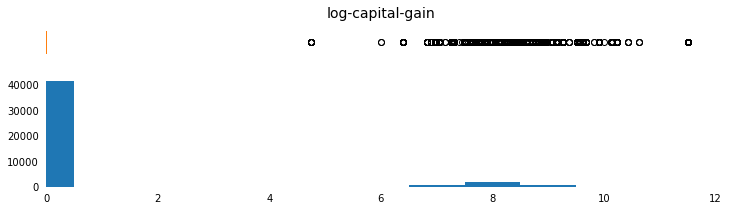

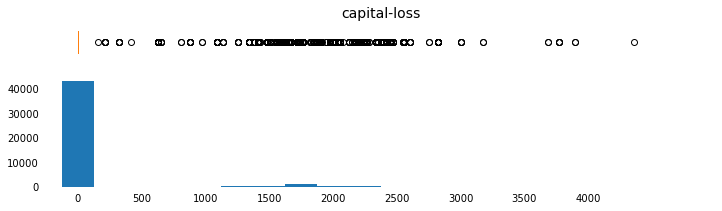

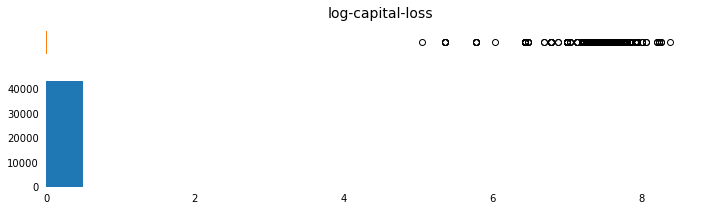

In [10]:
c['log-capital-gain'] = features_log_transformed['capital-gain']
c['log-capital-loss'] = features_log_transformed['capital-loss']
params = [('capital-gain',np.arange(0,100000,5000),[-5000,105000],
           np.arange(0,100000,10000)),
          ('log-capital-gain',np.arange(0,12,1),[0,12],np.arange(0,14,2)),
          ('capital-loss',np.arange(0,4500,250),[-250,5000],np.arange(0,4500,500)),
          ('log-capital-loss',np.arange(0,8,1),[0,9],np.arange(0,10,2))]
for field, bins, xlim_list, x_tick_list in params:
    plot_continuous_distributions(field, bins, xlim_list, x_tick_list)
c = c.drop(columns=['log-capital-gain','log-capital-loss'])

## Normalizing Numerical Features

In addition to transforming highly skewed features, it is also good practice to scale numerical features. This does not change the shape of the distribution like a log transform. It does, however, ensure that each feature is treated equally when applying supervised learning.

Note that the capital-gain and capital-loss fields were already log-transformed and are now being min-max-scaled.

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = \
    pd.DataFrame(data = features_log_transformed)

features_log_minmax_transform[numerical] = \
    scaler.fit_transform(features_log_transformed[numerical])

Visualize the change.

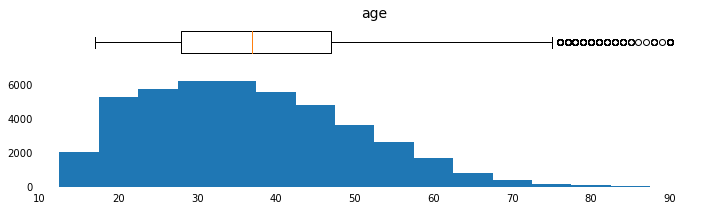

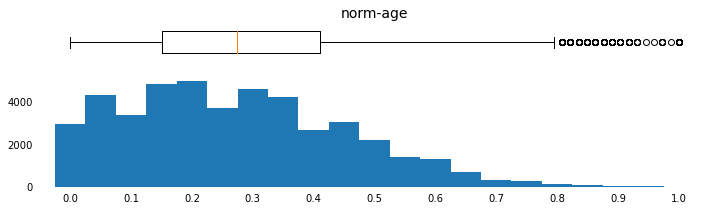

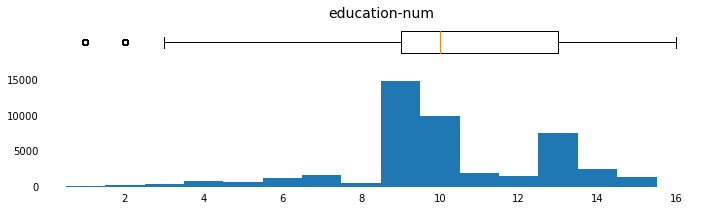

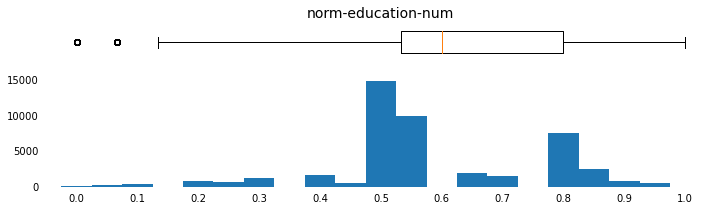

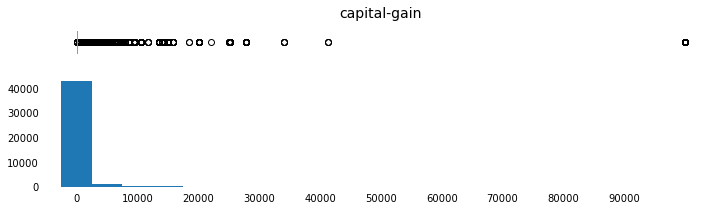

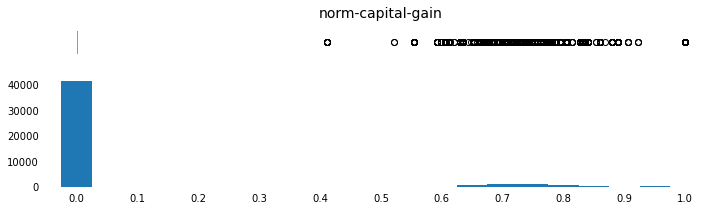

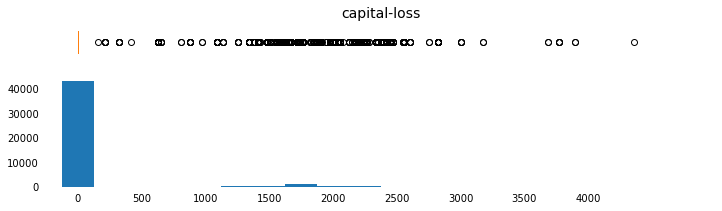

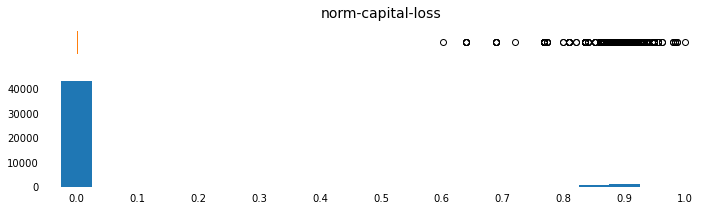

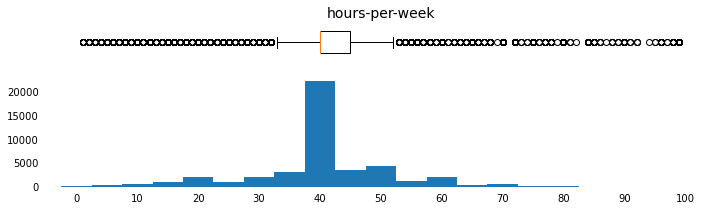

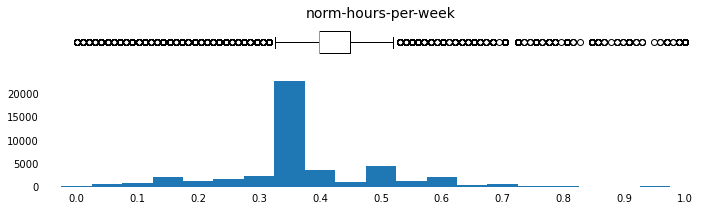

In [12]:
for col in numerical:
    c['norm-' + col] = features_log_minmax_transform[col]
params = [('age',np.arange(15,95,5),[10,95],np.arange(10,100,10)),
          ('norm-age',np.arange(0,1.05,0.05),[-0.05,1.05],np.arange(0,1.1,0.1)),
          ('education-num',np.arange(0,17,1),[0,17],np.arange(2,18,2)),
          ('norm-education-num',np.arange(0,1.05,0.05),[-0.05,1.05],np.arange(0,1.1,0.1)),
          ('capital-gain',np.arange(0,100000,5000),[-5000,105000],
           np.arange(0,100000,10000)),
          ('norm-capital-gain',np.arange(0,1.05,0.05),[-0.05,1.05],np.arange(0,1.1,0.1)),
          ('capital-loss',np.arange(0,4500,250),[-250,5000],np.arange(0,4500,500)),
          ('norm-capital-loss',np.arange(0,1.05,0.05),[-0.05,1.05],np.arange(0,1.1,0.1)),
          ('hours-per-week',np.arange(0,100,5),[-5,105],np.arange(0,110,10)),
          ('norm-hours-per-week',np.arange(0,1.05,0.05),[-0.05,1.05],np.arange(0,1.1,0.1))]
for field, bins, xlim_list, x_tick_list in params:
    plot_continuous_distributions(field, bins, xlim_list, x_tick_list)
c = c.drop(columns=c.columns[c.columns.str.contains('norm')])

## One-Hot Encode Categoricals

Learning algorithms generally expect numeric input. This dataset has 8 features that are categorical, which will need to be converted. This is generally accomplished with one-hot encoding the data. The pandas.get_dummies() method will be used for one-hot encoding.

The target label, income, must also be converted. Since there are only two possible categories, we can avoid using one-hot encoding and simply encode those categories as 0 or 1.

In [13]:
features_final = pd.get_dummies(features_log_minmax_transform)

before_encoding_cols = len(features_log_minmax_transform.columns)
after_encoding_cols = len(features_final.columns)

print("Before one-hot encode: {} features".format(before_encoding_cols))
print(" After one-hot encode: {} features".format(after_encoding_cols))

Before one-hot encode: 13 features
 After one-hot encode: 103 features


In [14]:
labels_final = (labels_raw
                .replace('<=50K',0)
                .replace('>50K',1))

## Shuffle and Split the Data

Use an 80⁄20 Training/Testing split.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    labels_final, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

print("Training set: {} samples".format(X_train.shape[0]))
print(" Testing set: {} samples".format(X_test.shape[0]))

Training set: 36177 samples
 Testing set: 9045 samples


## Write to File

In [16]:
for data_subset, name in [(X_train, 'X_train'),
                          (X_test,  'X_test'),
                          (y_train, 'y_train'),
                          (y_test,  'y_test')]:
    data_subset.to_csv(name + '.csv')

# Benchmark Several Default Machine Learning Models

The specific tasks break down as follows:

- Consider the performance of a Naive Predictor.
- Qualitatively analyze the suitability of each model to the dataset being explored.
- Create a Training and Predicting pipeline to facilitate quick training of several models using various sizes of training data.
- Select Top Model and discuss results.

In [17]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as pl
import numpy as np

import matplotlib.patches as mpatches

In [18]:
y_train = pd.read_csv('y_train.csv',
                      index_col=0)
y_test = pd.read_csv('y_test.csv',
                     index_col=0)
y = y_train.append(y_test)

In [19]:
X_train = pd.read_csv('X_train.csv',
                      index_col=0)
X_test = pd.read_csv('X_test.csv',
                     index_col=0)
X = X_train.append(X_test)

# Consider the Performance of a Naive Predictor

Remember the following definitions from a confusion matrix:

- True Positive: Both predicted and actually positive.
- True Negative: Both predicted and actually negative.
- False Negatives: Predicted negative, but actually positive.
- False Positive: Predicted positive, but actually negative.

- Precision focuses on the predicted positive values in the dataset.
- Recall focuses on the actually positive values in the dataset.

In [20]:
total = y['income'].count()
total_actual_positives = y['income'].sum()

print('      Total Datapoints: {}'.format(total))
print('Total Actual Positives: {}'.format(total_actual_positives))
print(' Actual Positive Ratio:    {:1.1%}'.format(total_actual_positives/total))

      Total Datapoints: 45222
Total Actual Positives: 11208
 Actual Positive Ratio:    24.8%


A naive predictor, in this case, would the entire dataset is positive. Note that this would clearly result in an accuracy less than 50%, since the actual positives are less than half of the total datapoints. So in general the opposite prediction would be the more appropriate naive prediction. But, in this specific problem, predicting that everyone earns less than $50K is not useful since in the problem setup this would mean zero people are possible donors.

Note also that in this case it is more important for a model to precisely predict those making more than $50K than it is for the model to recall those individuals. So, I use a  value of 0.5 that places more emphasis on precision.

The following definitions for TP, TN, FP, and FN are specific to the naive predictor.

In [21]:
TP = total_actual_positives
TN = 0
FP = total - total_actual_positives
FN = 0

beta = 0.5
accuracy = (TP+TN) / (TP+TN+FP+FN)
precision = TP / (TP+FP)
recall = TP / (TP+FN)
fscore = (1 + beta**2)*(precision*recall)/(beta**2*precision + recall)

print('   Accuracy:  {:1.1%}'.format(accuracy))
print('  Precision:  {:1.1%}'.format(precision))
print('     Recall: {:1.1%}'.format(recall))
print('F_0.5 Score:  {:3.1%}'.format(fscore))

   Accuracy:  24.8%
  Precision:  24.8%
     Recall: 100.0%
F_0.5 Score:  29.2%


# Qualitatively Analyze the Suitability of Possible Models

The following supervised learning models are some of those available in scikit-learn:

**Gaussian Naive Bayes**

- ***GaussianNB*** - from sklearn.naive_bayes import GaussianNB

**Decision Trees**

- ***DecisionTreeClassifier*** - from sklearn.tree import DecisionTreeClassifier

**Ensemble Methods**

- ***Bagging*** - from sklearn.ensemble import BaggingClassifier
- ***AdaBoost*** - from sklearn.ensemble import AdaBoostClassifier
- ***Random Forest*** - from sklearn.ensemble import RandomForestClassifier
- ***Gradient Boosting*** - from sklearn.ensemble import GradientBoostingClassifier

**K-Nearest Neighbors**

- ***KNeighbors** - from sklearn.neighbors import KNeighborsClassifier

**Stochastic Gradient Descent Classifier**

- ***SGDC*** - from sklearn.linear_model import SGDClassifier

**Support Vector Machines**

- ***SVM*** - from sklearn.svm import SVC

**Logistic Regression**

- ***Logistic Regression*** - from sklearn.linear_model import LogisticRegression


# Qualitative Analysis

### Gaussian Naive Bayes 1
Real-World Applications: Real-time predictions, text classification, spam filtering, sentiment analysis
Strengths: Fast, so useful with very large data sets. Requires less training data than some other models, like logistic regression.
Weaknesses: Assumes independent features, which may not be accurate
Good candidate?: Gaussian Naive Bayes are sutiable for binary classification tasks. But, the task does not involve text classification, which seems to be Naive Bayes’ primary application. May be suitable.


### Decision Trees 2
Real-World Applications: Broad application; wherever comprehensible rules are needed for a classification task.
Strengths: Rules are easily understood. Once trained, predictions are computationally efficient.
Weaknesses: Less appropriate for estimation tasks where the output is continuous. Computationally inefficient to train. Tendency to overfit the data.
Good candidate?: Decision trees are suitable for binary classification tasks. Likely to be suitable.


### Ensemble Methods 3, 4, 5
Real-World Applications: Remote sensing, person recognition, malware detection, fraud detection.
Strengths: Almost never overfit.
Weaknesses: Not interpretable. Computationally expensive.
Good candidate?: Yes, similar to the decision tree, which are often the weak learner of choice used with these algorithms. Likely to be suitable.


### K-Nearest Neighbors 6
Real-World Applications: economic forecasting, data compression, genetics.
Strengths: Easy to understand and implement, computationally efficient training.
Weaknesses: Computationally expensive testing, not well-suited to high-dimensional data because there may not be much distance between nearest and farthest neighbor.
Good candidate?: The data may be too high-dimensional, but testing is needed to determine if this is true. May be suitable.


### Stochastic Gradient Descent Classifier 7
Real-World Applications: SGD is a popular algorithm for training a wide range of models in machine learning.
Strengths: Limited available information on using SGD indpendently.
Weaknesses: Limited available information on using SGD indpendently.
Good candidate?: Limited available information on using SGD independently. In most cases, it seems to be used as an algorithm to train other types of models. Unknown, testing necessary.


### Support Vector Machines 8
Real-World Applications: Image classification, handwriting recognition, text and hypertext categorization.
Strengths: Effective with high-dimensional data. Tolerant of outliers.
Weaknesses: Computationally-inefficient on large datasets. Difficult to determine the optimal kernel to use. Not interpretable.
Good candidate?: Likely to be suitable.


### Logistic Regression 9, 10
Real-World Applications: Image segmentation and categorization, handwriting recognition, any application requiring classification.
Strengths: Outputs have a nice probabilistic interpretation. Easily updated model.
Weaknesses: Underperforms when there are multiple or non-linear decision boundaries.
Good candidate?: Depends on the linearity of the data. Unknown, testing necessary.

## Create a Training and Prediction Pipeline

In [22]:
from time import time
from sklearn.metrics import (fbeta_score,
                             accuracy_score)

The following utility function calculates training time, **prediction time, accuracy scores, and f-scores**. The predictions, accuracies, and f-scores are calculated for the testing data as well as a subset of the training data.

In the following function:

- .values will give the values in an array. (shape: (n,1)
- .ravel will convert that array shape to (n, )

In [23]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    results = {}
    
    start = time()
    learner = learner.fit(X_train[:sample_size],
                          y_train[:sample_size].values.ravel())
    end = time() 
    results['train_time'] = end - start
        
    start = time() # Get start time
    test_preds = learner.predict(X_test)
    train_preds = learner.predict(X_train[:300]) # Get predictions on the first 300 training samples
    end = time() # Get end time
    results['pred_time'] = end - start

    results['acc_train'] = accuracy_score(y_train[:300].values.ravel(), train_preds)
    results['acc_test'] = accuracy_score(y_test, test_preds)
    results['f_train'] = fbeta_score(y_train[:300].values.ravel(), train_preds, 0.5)
    results['f_test'] = fbeta_score(y_test, test_preds, 0.5)

    return results

Import then Initialize the **default models** that will be considered. Determine the counts of samples for 1%, 10%, 100% of the training data.

In [24]:
from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import SGDClassifier

from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression

In [25]:
random_state = 42

clf_1 = GaussianNB()
clf_2 = DecisionTreeClassifier(random_state=random_state)
clf_3 = BaggingClassifier(random_state=random_state)
clf_4 = AdaBoostClassifier(random_state=random_state)
clf_5 = RandomForestClassifier(random_state=random_state)
clf_6 = GradientBoostingClassifier(random_state=random_state)
clf_7 = KNeighborsClassifier()
clf_8 = SGDClassifier(random_state=random_state)
clf_9 = SVC(random_state=random_state)
clf_10 = LogisticRegression(random_state=random_state)

Determine the count of samples for **1%, 10%, and 100%** of the **training data**.

In [26]:
samples_100 = len(y_train)
samples_10 = int(round(0.1 * len(y_train)))
samples_1 = int(round(0.01 * len(y_train)))

Collect results on the learners.

In [27]:
run = True
if run == True:
    results = {}

    for clf in [clf_1, clf_2, clf_3, clf_4, clf_5,
                clf_6, clf_7, clf_8, clf_9, clf_10]:

        clf_name = clf.__class__.__name__
        results[clf_name] = {}
        for i, samples in enumerate([samples_1, samples_10, samples_100]):
            results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

C:\Users\Marc-Aurelien\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass beta=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\Marc-Aurelien\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass beta=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\Marc-Aurelien\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass beta=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\Marc-Aurelien\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass beta=0.5 as keyword args. From version 0.25 passing these as positional arguments wi

**The following visualization code displays the results for the various learners.**

In [28]:
def evaluate(results, accuracy, f1):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = pl.subplots(2, 3, figsize = (18,8))

    # Constants
    bar_width = 0.175
    colors = ['#1170aa','#ffbc79','#5fa2ce', '#c85200', '#c8d0d9']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width+0.15, 
                                  results[learner][i][metric], 
                                  width = bar_width,
                                  color = colors[k])
                ax[j//3, j%3].set_xticks([0.5, 1.5, 2.5])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlim((-0.1, 3.1))
                for spine in ax[j//3, j%3].spines.values():
                    spine.set_visible(False)
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    pl.legend(handles = patches, bbox_to_anchor = (-.80, 2.45), \
              loc = 'upper center', borderaxespad = 0., ncol = 5, frameon=False, fontsize = 12)
    
    # Aesthetics
    pl.suptitle("Performance Metrics for Supervised Learning Models", fontsize = 16, y = 1)
    pl.show()

In [29]:
first_five_keys = list(results.keys())[:5]
last_five_keys = list(results.keys())[5:]
first_five_results = {key: results[key] for key in first_five_keys}
last_five_results = {key: results[key] for key in last_five_keys}

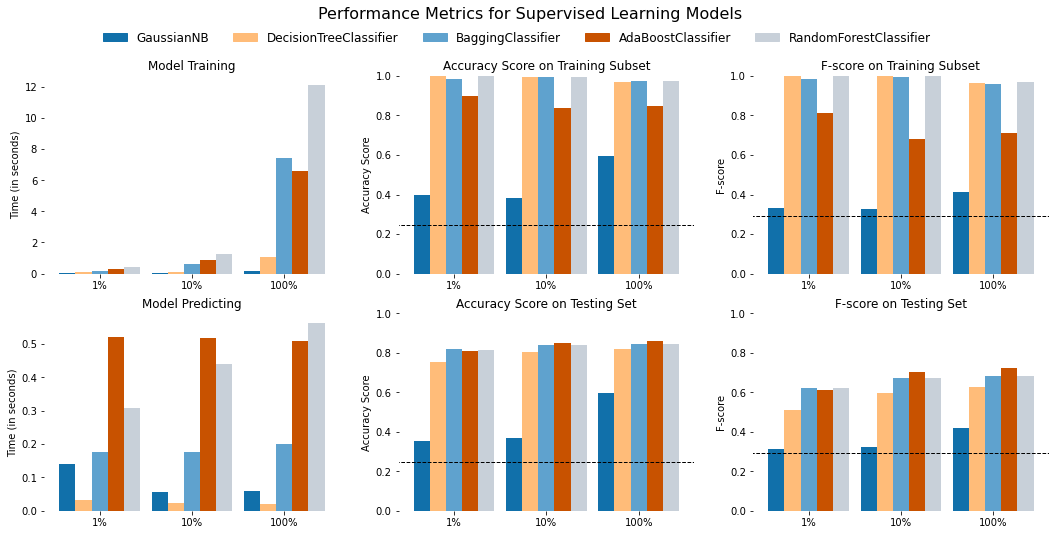

In [30]:
evaluate(first_five_results, accuracy, fscore)

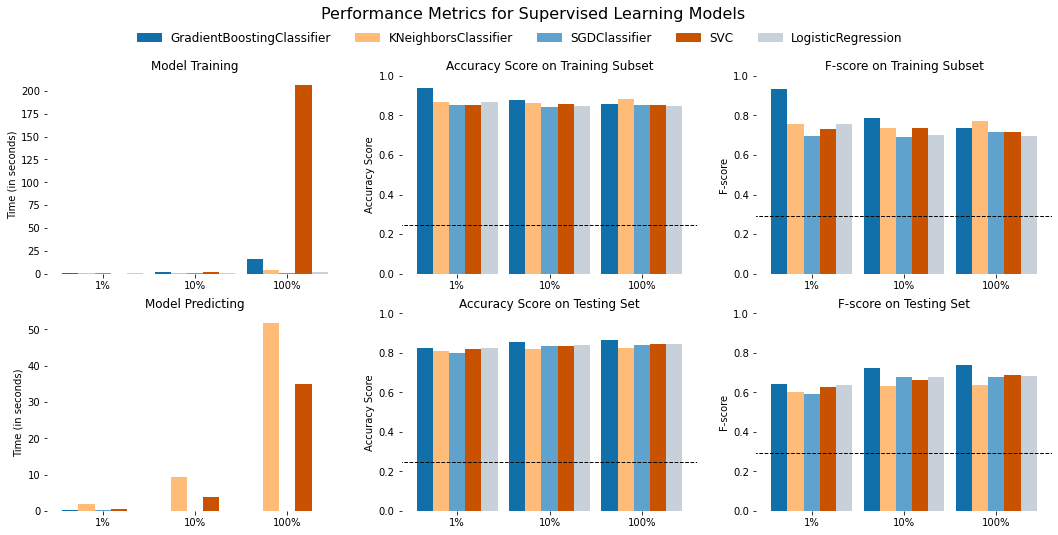

In [31]:
evaluate(last_five_results, accuracy, fscore)

In [32]:
r = (pd.DataFrame(results)
     .T
     .drop(columns=[0,1])
     .rename(columns={2:'parameters'})
     .reset_index()
     .rename(columns={'index':'model'}))
copy = r.copy()
params = pd.DataFrame()
for model in r['model']:
    param_dict = copy[copy['model']==model]['parameters'].values[0]
    p = (pd.DataFrame(param_dict,
                      [model])
         .reset_index()
         .rename(columns={'index':'model'}))
    params = (params.append(p))
params = (params
          .reset_index(drop=True))
for time in ['train_time','pred_time']:
    params[time] = params[time].round(1)
for acc in ['acc_train','acc_test','f_train','f_test']:
    params[acc] = (params[acc] * 100.).round(1)
params['acc_delta'] = params['acc_train'] - params['acc_test']
params['f_delta'] = params['f_train'] - params['f_test']

In [33]:
def sort_params_by(parameter, params):
    params = (params
              .sort_values([parameter],
                           ascending=False)
              .reset_index(drop=True))
    params['acc_delta'] = params['acc_train'] - params['acc_test']
    params['f_delta'] = params['f_train'] - params['f_test']
    params.index += 1
    return params

In [34]:
sort_params_by('acc_test', params)

,model,train_time,pred_time,acc_train,acc_test,f_train,f_test,acc_delta,f_delta
1,GradientBoostingClassifier,16.3,0.1,85.7,86.3,73.4,74.0,-0.6,-0.6
2,AdaBoostClassifier,6.6,0.5,85.0,85.8,71.2,72.5,-0.8,-1.3
3,BaggingClassifier,7.4,0.2,97.3,84.3,95.9,68.3,13.0,27.6
4,RandomForestClassifier,12.1,0.6,97.7,84.2,97.1,68.1,13.5,29.0
5,SVC,206.1,34.8,85.3,84.2,71.7,68.5,1.1,3.2
6,LogisticRegression,1.3,0.0,84.7,84.2,69.9,68.3,0.5,1.6
7,SGDClassifier,0.8,0.0,85.3,84.1,71.4,67.9,1.2,3.5
8,KNeighborsClassifier,4.4,51.9,88.3,82.3,77.2,63.7,6.0,13.5
9,DecisionTreeClassifier,1.1,0.0,97.0,81.9,96.4,62.8,15.1,33.6
10,GaussianNB,0.2,0.1,59.3,59.8,41.2,42.1,-0.5,-0.9


In [35]:
sort_params_by('f_test', params)[:1]

,model,train_time,pred_time,acc_train,acc_test,f_train,f_test,acc_delta,f_delta
1,GradientBoostingClassifier,16.3,0.1,85.7,86.3,73.4,74.0,-0.6,-0.6


In [36]:
sort_params_by('acc_train', params)[:5]

,model,train_time,pred_time,acc_train,acc_test,f_train,f_test,acc_delta,f_delta
1,RandomForestClassifier,12.1,0.6,97.7,84.2,97.1,68.1,13.5,29.0
2,BaggingClassifier,7.4,0.2,97.3,84.3,95.9,68.3,13.0,27.6
3,DecisionTreeClassifier,1.1,0.0,97.0,81.9,96.4,62.8,15.1,33.6
4,KNeighborsClassifier,4.4,51.9,88.3,82.3,77.2,63.7,6.0,13.5
5,GradientBoostingClassifier,16.3,0.1,85.7,86.3,73.4,74.0,-0.6,-0.6


In [37]:
sort_params_by('f_train', params)[:5]

,model,train_time,pred_time,acc_train,acc_test,f_train,f_test,acc_delta,f_delta
1,RandomForestClassifier,12.1,0.6,97.7,84.2,97.1,68.1,13.5,29.0
2,DecisionTreeClassifier,1.1,0.0,97.0,81.9,96.4,62.8,15.1,33.6
3,BaggingClassifier,7.4,0.2,97.3,84.3,95.9,68.3,13.0,27.6
4,KNeighborsClassifier,4.4,51.9,88.3,82.3,77.2,63.7,6.0,13.5
5,GradientBoostingClassifier,16.3,0.1,85.7,86.3,73.4,74.0,-0.6,-0.6


## Select Top Model and Discuss Results

As shown in the table and charts above, the top-performing algorithm is the **GradientBoostingClassifier**.

- It has the highest accuracy and f-score on the test set.

- It has the fifth highest accuracy and f-score on the training set, but all models that outperformed it on these two metrics overfit the data.

- The evidence of the overfit is the large deltas these models have between their performance on the training set and testing set. These deltas range from 6 percentage points on the low end to 33.6 percentage points on the high end. 

- The GradientBoostingClassifier, on the other hand, actually performs slightly better on the test set than on the training set.

- The training and prediction time both only take single-digits seconds to complete. The SVC classifier took the longest to train, by far, while the KNeighborsClassifier took the longest to predict.

As an ensemble learner that is suited to classification, the GradientBoostingClassifier is well-suited to this dataset.

## Model Description 1, 2, 3

Sklearn’s **GradientBoostingClassifier** is one specific implementation of Gradient Boosting. GB is a group of algorithms that are referred to as ensemble learners because they involve creating groups, or ensembles, of many other “weak learners” which vote on the output of the overall group. Weak learners is a term used to describe a simple model that is able to correctly predict more often than a random choice, but which are not powerful enough to be used as a predictor on their own. These weak learners are generally decision trees. These weak learners are sometimes referred to as decision stumps because their structure is often very limited. Often, they are a single decision node, for example.

**Gradient Boosting** begins by fitting a single weak learner on the dataset. New, additional weak learners are iteratively added to the ensemble. Those new learners are specifically trained to reduce error between the model’s predictions and the true labels in the dataset. By “focusing on the weak spots,” the performance of the overall model is improved with each training iteration. Once the model reaches a certain performance and/or complexity, the model training is considered completed and no additional learners are added. The trained model makes predictions by having the ensembled learners vote on each prediction the model makes.

# Optimize the Top-Performing Model

- Optimize Hyperparameters to find the top-performing model.
- Evaluate the Performance of the tuned model.
- Extract Feature Importance from the trained model.
- Quantify Effects of Feature Selecting by training a different model on only the most important features.

In [39]:
y_train = pd.read_csv('y_train.csv',
                      index_col=0)
y_test = pd.read_csv('y_test.csv',
                     index_col=0)
y = y_train.append(y_test)

## Tune Hyperparameters

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (make_scorer,
                             fbeta_score)

### Define Functions to Summarize Performance Data

In [41]:
def reshape_grid_search_results(raw_results):
    r = (raw_results
         .drop(columns=['mean_fit_time', 'std_fit_time', 
                        'mean_score_time', 'std_score_time', 'params',
                        'mean_test_score', 'std_test_score']))
        
    r.columns = r.columns.str.replace('param_','')
    r = (r
         .set_index(['learning_rate',
                     'max_depth',
                     'min_samples_leaf',
                     'rank_test_score'])
         .stack()
         .reset_index()
         .rename(columns={'level_4':'split',
                          0:'score'}))
    r['split'] = r['split'].str.extract('([0-5])')
    r['score'] *= 100.
    
    return r

In [42]:
def summarize_parameter(r, parameter):
    mean = (r[[parameter,'score']]
            .groupby(parameter)
            .mean()
            .rename(columns={'score':'mean'}))
    std = (r[[parameter,'score']]
           .groupby(parameter)
           .std()
           .rename(columns={'score':'std'}))
    summary = (mean
               .join(std)
               .reset_index())
    
    return summary

### Define Functions to Visualize Model Performance

In [43]:
def plot_performance_histogram(r):
    plt.figure(figsize=(11,8.5)) # figsize=(11,8.5)
    ax = plt.gca()
    
    ax.hist(r['score'],
            bins=np.arange(0,105,5),
            align='mid')
    
    ax.set_xticks(np.arange(0,105,5))
    ax.set_xlim([0,100])
    
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.tick_params(
        axis='y',
        left=False,
        right=False,
        labelleft=False)
    
    ymax = ax.get_ylim()[1]
        
    rects = ax.patches
    for n, rect in enumerate(rects):
        height = rect.get_height()
        if height > 0:
            plt.gca().text(rect.get_x() + rect.get_width() / 2,
                           height + ymax/67,
                           str(int(height)),
                           ha='center',
                           va='center')
    
    title_str = '''
    Model Accuracy Distribution\nTotal Models Trained: {}
    '''.format(r['score'].count())
    ax.set_title(title_str,
                 fontsize=14)

In [44]:
def plot_performance_curve(r, param):
    plt.figure(figsize=(8,6)) # figsize=(8,6)
    ax = plt.gca()
    
    s = summarize_parameter(r, param)
    
    ax.set_title('Performance Curve\n' + param)
    ax.set_xticks(s[param])
    ax.set_ylim([30,80])
    ax.set_ylabel('Score')
    
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    ax.grid()
    ax.tick_params(
        axis='x',
        bottom=False)
    ax.tick_params(
        axis='y',
        left=False,
        right=False)
    
    ax.plot(s[param], 
            s['mean'], 
            'o-',
            color='navy')
    ax.fill_between(s[param], 
                    s['mean']-s['std'], 
                    s['mean']+s['std'], 
                    alpha=0.1,
                    color='navy')

### Define Function to Iteratively Tune Hyperparameters

- Define the model.
- Define the hyperparameter search space.
- Define the scorer.
- beta = 0.5 places more emphasis on precision.
- Define the GridSearch object.
- n_jobs=-1: utilizes all processors in parallel.
- verbose=2: means more messages are printed during training.
- Fit the GridSearch.
- Visualize using Performance Histograms and Performance Curves.
- Iterate as required.

In [45]:
def tune_and_visualize(clf, parameters):
    scorer = make_scorer(fbeta_score, 
                         beta=0.5)
    grid_obj = GridSearchCV(clf, 
                            parameters, 
                            scoring=scorer,
                            n_jobs=-1,
                            verbose=2)
    
    grid_fit = grid_obj.fit(X_train, 
                            y_train.values.ravel())
    raw_results = pd.DataFrame(grid_fit.cv_results_)
    
    r = reshape_grid_search_results(raw_results)
    
    plot_performance_histogram(r)
    
    for param in parameters.keys():
        plot_performance_curve(r, param)
    
    return r, raw_results, grid_fit

### Begin Hyperparameter Tuning

In [ ]:
clf = GradientBoostingClassifier(random_state=42)
parameters = {'learning_rate'     : np.arange( 0.4,  2.4, 0.4), # Default: 0.1
              'max_depth'         : np.arange(   1,   6,    1), # Default: 3
              'min_samples_leaf'  : np.arange(0.05, 0.4, 0.05)} # Default: 1

pass_1_r, pass_1_raw, pass_1_grid_fit = tune_and_visualize(clf, parameters)

Fitting 5 folds for each of 175 candidates, totalling 875 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.0min


**Notes from first pass:**
- The top 10% of the configurations all had min_samples_leaf <= 0.1.
- Mean performance drops and the standard deviation increases sharply with learning_rate > 1.2.

In [ ]:
clf = GradientBoostingClassifier(random_state=42)
parameters = {'learning_rate'     : np.arange( 0.2,  1.6,  0.2), # Default: 0.1
              'max_depth'         : np.arange(   1,    6,    1), # Default: 3
              'min_samples_leaf'  : np.arange(0.02, 0.12, 0.02)} # Default: 1

pass_2_r, pass_2_raw, pass_2_grid_fit = tune_and_visualize(clf, parameters)

**Notes from second pass:**

- Performance appears to decrease monotonically with increasing min_samples_leaf. The training set consists of 36177 instances.

- Since we are using the default 5-fold validation, each model is trained on roughly 7235 instances. So, with min_samples_leaf of 0.02, each leaf must contain a minimum of roughly 145 instances. Given this, it may make sense to simply remove it as an optimization parameter since the default value is 1 node per leaf.

- Performance across the other hyperparameters appears stable, except for a drop with learning_rate > 1.2.

In [ ]:
clf = GradientBoostingClassifier(random_state=42)
parameters = {'learning_rate'     : np.arange( 0.1,  1.3,  0.1), # Default: 0.1
              'max_depth'         : np.arange(   1,    6,    1), # Default: 3
              'min_samples_leaf'  : [1]}                         # Default: 1

pass_3_r, pass_3_raw, pass_3_grid_fit = tune_and_visualize(clf, parameters)

**Notes from third pass:**

Mean performance appears fairly stable across hyperparameter ranges, indicating further optimization will yield diminishing returns.

## Final Model Evaluation

In [ ]:
def plot_overlaid_performance_histograms(rs):
    plt.figure(figsize=(11,8.5))
    ax = plt.gca()
    
    for n, r in enumerate(rs):
        ax.hist(r['score'],
                bins=np.arange(0,105,5),
                alpha=0.35,
                align='mid',
                density=True,
                label='Pass ' + str(n+1))

    ax.set_xticks(np.arange(5,90,5))
    ax.set_xlim([5,85])
    
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.ylim([0,0.18])
    ymax = ax.get_ylim()[1]
        
    rects = ax.patches
    for n, rect in enumerate(rects):
        height = rect.get_height()
        if height > 0:
            # total area under each histogram with
            #      hist density parameter sums to 0.2.
            #      Factor of 5 corrects this.
            plt.gca().text(rect.get_x() + rect.get_width() / 2,
                           height + ymax/67,
                           '{}%'.format(int(round(height*100*5))),
                           ha='center',
                           va='center',                            
                           color=rect.get_facecolor(),
                           alpha=1)
    
    ax.set_xlabel('Score',
                  fontsize=12)
    ax.set_ylabel('% of Models Trained on that Pass',
                  fontsize=12)
            
    ax.tick_params(
        axis='y',
        left=False,
        labelleft=False)
    
    ax.legend(
    fancybox=True,
    loc=9,
    ncol=4,
    facecolor='white',
    edgecolor='white',
    framealpha=1,
    fontsize=12)

    ax.set_title('Performance Histograms by Grid Search Iteration',
                 fontsize=14)

In [ ]:
plot_overlaid_performance_histograms([pass_1_r,
                                      pass_2_r,
                                      pass_3_r])

As shown in the overlaid histograms above, each successive grid search iteration resulted in improved performance distribution due to improved parameter search.

In [ ]:
unoptimized = (GradientBoostingClassifier(random_state=42)
               .fit(X_train, y_train.values.ravel()))

In [ ]:
unoptimized_preds = unoptimized.predict(X_test)
pass_1_preds = pass_1_grid_fit.best_estimator_.predict(X_test)
pass_2_preds = pass_2_grid_fit.best_estimator_.predict(X_test)
pass_3_preds = pass_3_grid_fit.best_estimator_.predict(X_test)

naive_pred_acc = 0.248
unoptimized_acc = accuracy_score(y_test, unoptimized_preds)
pass_1_acc = accuracy_score(y_test, pass_1_preds)
pass_2_acc = accuracy_score(y_test, pass_2_preds)
pass_3_acc = accuracy_score(y_test, pass_3_preds)

naive_pred_f_05 = 0.292
unoptimized_f_05 = fbeta_score(y_test, unoptimized_preds, beta = 0.5)
pass_1_f_05 = fbeta_score(y_test, pass_1_preds, beta = 0.5)
pass_2_f_05 = fbeta_score(y_test, pass_2_preds, beta = 0.5)
pass_3_f_05 = fbeta_score(y_test, pass_3_preds, beta = 0.5)

As shown in the scores calculated and then tabulated above, an unoptimized model is surprisingly good. The unoptimized model outperformed all models tuned during the Pass 1 and it outperformed all models in Pass 2 on F-score.

The best model constructed during Pass 3, however, outperformed the unoptimized model on both metrics.

## Feature Importances

In [ ]:
def feature_plot(importances, X_train, y_train):
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (12,6))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center",
            label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center",
            label = "Cumulative Feature Weight")
    
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylim([0,1])
    
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(
    fancybox=True,
    loc=9,
    ncol=4,
    facecolor='white',
    edgecolor='white',
    framealpha=1,
    fontsize=12)
    
    for spine in plt.gca().spines.values():
        spine.set_visible(False);
        
    plt.tick_params(
        axis='x',
        bottom=False)
    plt.tick_params(
        axis='y',
        left=False,
        right=False,
        labelleft=False)
    
    rects = plt.gca().patches
    for n, r in enumerate(rects):
        height = r.get_height()
        plt.gca().text(r.get_x() + r.get_width() / 2,
                       height+.025,
                       '{:1.2f}'.format(height),
                       ha='center',
                       va='center')
    
    plt.tight_layout()

In [ ]:
importances = pass_3_grid_fit.best_estimator_.feature_importances_
feature_plot(importances, X_train, y_train)

Some of the most important features are intuitive. Others are not.

- I expect that people who are financially sophisticated enough to report their capital gains and capital losses would also have relatively high earning potential.

- I would also expect that more educated and older individuals to have increased earning potential.

- It is surprising to me that being married is the most important factor. I would have expected it to be important, but less important than the other factors in the top 5.

### Feature Selection

The top-five most important features are shown in the graph above and listed below.

- marital-status_Married-civ-spouse - Binary, whether individual is married and civil with their spouse.
- capital-gain - Continuous, how much capital gain the individual reported.
- education-num - Categorical, a proxy for how well-educated the person is.
- capital-loss - Continuous, how much capital loss the individual reported.
- age - Discrete, how old the individual is.

In [ ]:
from sklearn.base import clone

X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

reduced_clf = ((clone(pass_3_grid_fit.best_estimator_))
               .fit(X_train_reduced, y_train.values.ravel()))

reduced_predictions = reduced_clf.predict(X_test_reduced)

reduced_acc = accuracy_score(y_test, reduced_predictions)
reduced_f_05 = fbeta_score(y_test, reduced_predictions, beta = 0.5)

The fully-optimized model performs slightly worse when trained on only the top five features tabulated above. Notably, it does perform worse than an unoptimized model trained on all the data, however. In this situation, training is not time- or resource-prohibitive, so there is not much sense in limiting the feature space to anything less than the full dataset.

I can imagine situations where this is not the case, however, and it is necessary to reduce the dimensionality of the training data even if there is a small negative impact to overall model performance.